# Notebook for generating plots of trained agents

This code will load the results for the specified experiments, generate plots, and save them in the `experiments_dir` directory

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import pandas as pd

In [35]:
params = {'legend.fontsize': 6,
                  "figure.autolayout": True,
                  'font.size': 8,
                  'pdf.fonttype':42,
                  'ps.fonttype':42}
plt.rcParams.update(params)

cm = 1 / 2.54  # for converting inches to cm
fig_size = (10.48 * cm, 6 * cm)  # these dimensions chosen to fit in latex column
    

* Set the directory in which all the experiments to be plotted together are stored.
* Set the list of subdirs (experiments) you want to include in the plots

In [36]:

all_experiments = ["/media/XXX/LaCie/aamas_2023/paper/alignment/3_landmarks_reward2",
                  "/media/XXX/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2"]
all_experiments = ["/media/XXX/LaCie/aamas_2023/all/3_landmarks//3_landmarks_reward2",
                  "/media/XXX/LaCie/aamas_2023/all/3_landmarks//3_landmarks_reward4"]
labels_to_print = {"0align": "$0%$-align",
                   "independent": "$0%$-align",
                   "centralized": "$100%$-align",
                   "75align": "$75%$-align",
                     "25align": "$25%$-align",

                  "50align": "$50%$-align",
                  "100align": "$100%$-align",
                  "naming_game_30msg_alpha10_temp30": "GC-game"}
correct_order = ["$0%$-align", "$50%$-align", "$100%$-align","GC-game" ]

"""
all_experiments = ["/media/XXX/LaCie/aamas_2023/paper/message_size"]
labels_to_print = {"naming_game_20msg_alpha10_temp30": "$m=20$",
                  "naming_game_30msg_alpha10_temp30": "$m=30$",
                  "naming_game_40msg_alpha10_temp30": "$m=40$"}
correct_order = ["$m=20$", "$m=30$", "$m=40$"]
ncols = 1


all_experiments = ["/media/XXX/LaCie/aamas_2023/paper/multiplier/3_landmarks"]
labels_to_print = {"naming_game_reward1": "$\\beta=1$",
                   "naming_game_reward2": "$\\beta=2$",
                  "naming_game_reward4": "$\\beta=4$",
                  "naming_game_reward8": "$\\beta=8$"}
correct_order = ["$\\beta=1$", "$\\beta=2$", "$\\beta=4$", "$\\beta=8$"]
ncols = 2
"""

'\nall_experiments = ["/media/elena/LaCie/aamas_2023/paper/message_size"]\nlabels_to_print = {"naming_game_20msg_alpha10_temp30": "$m=20$",\n                  "naming_game_30msg_alpha10_temp30": "$m=30$",\n                  "naming_game_40msg_alpha10_temp30": "$m=40$"}\ncorrect_order = ["$m=20$", "$m=30$", "$m=40$"]\nncols = 1\n\n\nall_experiments = ["/media/elena/LaCie/aamas_2023/paper/multiplier/3_landmarks"]\nlabels_to_print = {"naming_game_reward1": "$\\beta=1$",\n                   "naming_game_reward2": "$\\beta=2$",\n                  "naming_game_reward4": "$\\beta=4$",\n                  "naming_game_reward8": "$\\beta=8$"}\ncorrect_order = ["$\\beta=1$", "$\\beta=2$", "$\\beta=4$", "$\\beta=8$"]\nncols = 2\n'

In [106]:
# method for ploting training and evaluation plots

def produce_plots(all_experiments, labels_to_print, correct_order, best_reward, beta_values=[], max_step=1e12):
    best_reward_or=best_reward
    for experiments_dir in all_experiments:
        # ----- collect data -----
        list_of_experiments =  [o for o in os.listdir(experiments_dir) if os.path.isdir(experiments_dir + "/" + o)]
        results = {}
        for experiment in list_of_experiments:

            subdir = os.path.join(experiments_dir, experiment)
            eval_reward = pd.DataFrame()
            train_reward = pd.DataFrame()
            episode_len = pd.DataFrame()
            alignment = pd.DataFrame()
            train_x = []
            eval_x = []
            ctr=0
            for j, experiment_name in enumerate(os.listdir(subdir)):

                if(os.path.isdir(subdir+"/"+experiment_name)):

                    ctr+=1
                    if(experiment_name[:5]!="p_est" and experiment_name[:5]!="0_5di"):

                        if( True):
                            print(experiment_name)

                            r = []
                            r_t = []
                            l = []
                            x_ = []
                            a = []
                            y_ = []
                            result_raw = open(os.path.join(subdir, experiment_name, "result.json"), "r")

                            for result in result_raw:
                                dump = json.loads(result)

                                #if(ctr>5):
                                    #print(dump.keys())
                                a.append(dump["custom_metrics"].get("goal_alignment_mean"))
                                y_.append(dump["timesteps_total"])
                                r_t.append(dump["episode_reward_mean"])

                                metrics = dump.get("evaluation")
                                if metrics is not None:
                                    custom = metrics.get("custom_metrics")
                                    x_.append(dump["timesteps_total"])
                                    r.append(metrics["episode_reward_mean"])
                                    l.append(metrics["episode_len_mean"])

                            eval_reward = pd.concat(
                                [eval_reward, pd.DataFrame(r)], ignore_index=True, axis=1
                            )
                            episode_len = pd.concat(
                                [episode_len, pd.DataFrame(l)], ignore_index=True, axis=1
                            )
                            alignment = pd.concat([alignment, pd.DataFrame(a)], ignore_index=True, axis=1)
                            train_reward = pd.concat(
                                [train_reward, pd.DataFrame(r_t)], ignore_index=True, axis=1
                            )


                            if len(x_) > len(eval_x):
                                eval_x = x_
                            if len(y_) > len(train_x):
                                train_x = y_
                                
            new_results = {
                "eval_reward": eval_reward,
                "train_reward": train_reward,
                "episode_len": episode_len,
                "alignment": alignment,
                "train_x": train_x,
                "eval_x": eval_x,
            }
            #new_results = new_results[new_results.train_x < max_step]
            results[experiment] = new_results

        # -------------------------------------------------------------------------------------------------------

        # ----- plot training -----
        fig, axs = plt.subplots(2, figsize=(fig_size[0], fig_size[1] *1.5), sharex=True)
        slice=700
        i = 1
        n_exp = len(results)
        for label, result in results.items():

            label_to_print = labels_to_print[label]
            
            if best_reward_or == 0:
                beta = beta_values[label_to_print]
                best_reward = (1/2*1/beta + 1/2)*2


            axs[0].plot(result["train_x"][:slice], [el/best_reward for el in result["train_reward"][:slice].mean(axis=1)], label=label_to_print)
            axs[0].fill_between(
                result["train_x"][:slice],
                [el/best_reward for el in result["train_reward"][:slice].mean(axis=1)] - result["train_reward"][:slice].std(axis=1),
                [el/best_reward for el in result["train_reward"][:slice].mean(axis=1)] + result["train_reward"][:slice].std(axis=1),
                alpha=0.4,
            )
            if i == n_exp:
                handles, labels = axs[0].get_legend_handles_labels()
                order = []
                for el in correct_order:
                    for label_idx, actual_label in enumerate(labels):
                        if el ==actual_label:
                            print("actual label", actual_label)
                            order.append(label_idx)
                axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=ncols)
                #plt.grid()
                axs[0].set_ylabel("Training Reward, $R_{train}$")
                plt.xlabel("Timestep, \n $t_{train}$")

            axs[1].plot(result["train_x"][:slice], result["alignment"][:slice].mean(axis=1), label=label_to_print)
            axs[1].fill_between(
                result["train_x"][:slice],
                result["alignment"][:slice].mean(axis=1) - result["alignment"][:slice].std(axis=1),
                result["alignment"][:slice].mean(axis=1) + result["alignment"][:slice].std(axis=1),
                alpha=0.4,
            )
            if i == n_exp:

                axs[1].set_ylabel("Alignment, $A$")
                plt.xlabel("Timestep,\n  $t_{train}$")

            i += 1

        plt.tight_layout()
        plt.savefig(os.path.join(experiments_dir, "training.png"), dpi=300, bbox_inches='tight', transparent=True)
        plt.savefig(os.path.join(experiments_dir, "training.pdf"), dpi=300, bbox_inches='tight', transparent=True)
        plt.clf()
        
        
        # -------------------------------------------------------------------------------------------------------

        # ----- plot evaluation -----
        #best_reward=best_reward_or
        fig2, axs2 = plt.subplots(2, figsize=(fig_size[0], fig_size[1] *1.5), sharex=True)

        slice=70
        i = 1
        n_exp = len(results)
        for label, result in results.items():
            label_to_print = labels_to_print[label]
            
            if best_reward_or == 0:
                beta = beta_values[label_to_print]
                best_reward = (1/2*1/beta + 1/2)*2
                print("here",beta,label_to_print)

            axs2[0].plot(result["eval_x"][:slice], [el/best_reward for el in result["eval_reward"][:slice].mean(axis=1)], label=label_to_print)
            axs2[0].fill_between(
                result["eval_x"][:slice],
                [el/best_reward for el in result["eval_reward"][:slice].mean(axis=1)] - result["eval_reward"][:slice].std(axis=1),
                [el/best_reward for el in result["eval_reward"][:slice].mean(axis=1)] + result["eval_reward"][:slice].std(axis=1),
                alpha=0.4,
            )
            if i == n_exp:
                handles, labels = axs2[0].get_legend_handles_labels()
                order = []
                for el in correct_order:
                    for label_idx, actual_label in enumerate(labels):
                        if el ==actual_label:
                            order.append(label_idx)
                axs2[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=ncols)
                axs2[0].set_xlabel("Timestep, $t_{eval}$")
                axs2[0].set_ylabel("Evaluation Reward, $R_{eval}$")

            axs2[1].plot(result["eval_x"][:slice], result["episode_len"][:slice].mean(axis=1), label=label_to_print)
            axs2[1].fill_between(
                result["eval_x"][:slice],
                result["episode_len"][:slice].mean(axis=1) - result["episode_len"][:slice].std(axis=1),
                result["episode_len"][:slice].mean(axis=1) + result["episode_len"][:slice].std(axis=1),
                alpha=0.4,
            )
            if i == n_exp:

                axs2[1].set_xlabel("Timestep, \n $t_{eval}$")
                axs2[1].set_ylabel("Episode length, $L$")
            i += 1

        plt.tight_layout()
        # Uncomment this line for saving the plot
        plt.savefig(os.path.join(experiments_dir, "eval.png"), dpi=300, bbox_inches='tight', transparent=True)
        plt.savefig(os.path.join(experiments_dir, "eval.pdf"), dpi=300, bbox_inches='tight', transparent=True)

2022-10-25_15-45-03c6avdryz
2022-10-25_15-45-04bm2wcxvl
2022-10-25_15-45-03x9fwe020
2022-10-25_15-45-04uot8u57m
2022-10-25_15-45-04n0p3p3_l
100align
2022-10-26_10-47-46mqinyg2q
2022-10-26_10-47-46dpqioiym
2022-10-26_10-47-465x9bllxc
2022-10-26_10-47-46dd50e48j
2022-10-26_10-47-469_vrnfa0
naming_game_30msg_alpha10_temp30
2022-10-26_12-25-20w8srj295
2022-10-26_12-25-188gdhd1rh
2022-10-26_12-25-20nimyyq27
2022-10-26_12-25-01o6yt0lij
2022-10-26_12-25-1821o71ko5
0align
2022-10-26_21-30-01xyhjxjwe
2022-10-26_21-30-24u55v87fk
2022-10-26_21-30-01wrcqnjnt
2022-10-26_21-30-01ls1phtc9
2022-10-26_21-30-01dnx8o129
50align
$100%$-align
0      0.076699
1      0.109560
2      0.156375
3      0.227242
4      0.337587
         ...   
295    1.504640
296    1.507185
297    1.496810
298    1.495788
299    1.500702
Length: 300, dtype: float64
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,

<Figure size 412.598x354.331 with 0 Axes>

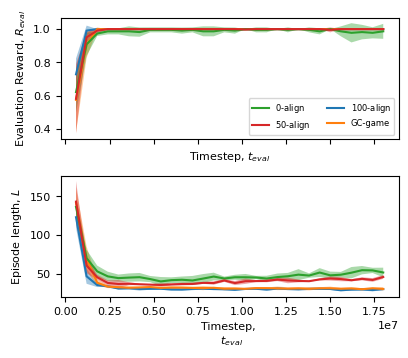

In [52]:
# produce figures for 4.1 (3 landmarks

all_experiments = ["/media/XXX/LaCie/aamas_2023/paper/alignment/3_landmarks_reward2"]

labels_to_print = {"0align": "$0%$-align",
                   "independent": "$0%$-align",
                   "centralized": "$100%$-align",
                   "75align": "$75%$-align",
                   "25align": "$25%$-align",
                   "50align": "$50%$-align",
                   "100align": "$100%$-align",
                   "naming_game_30msg_alpha10_temp30": "GC-game"}
correct_order = ["$0%$-align", "$50%$-align", "$100%$-align","GC-game" ]
beta = 2
best_reward = (1/2*1/beta + 1/2)*2
#               6: (6/21*1/beta + 15/21)}


produce_plots(all_experiments, labels_to_print, correct_order, best_reward)

2022-10-25_16-00-518o3o50rr
2022-10-25_16-00-159fewsxsl
2022-10-25_16-00-51_1nit794
2022-10-25_16-00-15c7r26f63
2022-10-25_16-00-51gkhmkea0
2022-10-26_12-23-36t0oywtay
2022-10-26_12-23-36opefz_kr
2022-10-26_12-23-36ek2iwteb
2022-10-26_12-23-3697ccqc0f
2022-10-26_12-23-36wpfw7t8i
2022-10-26_22-37-074duhqlmb
2022-10-26_22-37-10pmdoqrwi
2022-10-26_22-37-11jnmvgil6
2022-10-26_22-37-10i29_9g0t
2022-10-26_22-37-12aq1w9cnx
2022-10-26_12-23-36tnspdchd
2022-10-26_12-23-36y1qela3f
2022-10-26_12-23-361jzdlx2z
2022-10-26_12-23-36pt_blwdm
2022-10-26_12-23-36xdrwb902
actual label $0%$-align
actual label $50%$-align
actual label $100%$-align
actual label GC-game


<Figure size 412.598x354.331 with 0 Axes>

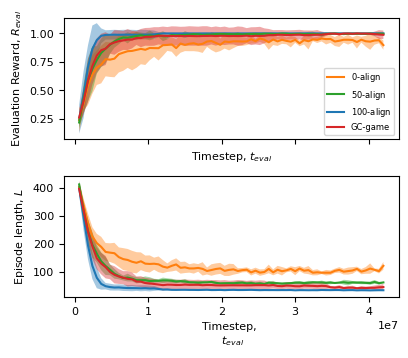

In [107]:
# produce figures for 4.1 (6 landmarks)
all_experiments = ["/media/XXX/LaCie/aamas_2023/paper/alignment/6_landmarks_reward2"]

labels_to_print = {"0align": "$0%$-align",
                   "independent": "$0%$-align",
                   "centralized": "$100%$-align",
                   "75align": "$75%$-align",
                   "25align": "$25%$-align",
                   "50align": "$50%$-align",
                   "100align": "$100%$-align",
                   "naming_game_30msg_alpha10_temp30": "GC-game"}
correct_order = ["$0%$-align", "$50%$-align", "$100%$-align","GC-game" ]
beta = 2
best_reward = (6/21*1/beta + 15/21)*2

produce_plots(all_experiments, labels_to_print, correct_order, best_reward, max_step=3e7)

2022-10-27_18-28-16zrsi2xie
2022-10-27_18-28-16a1oh_44r
2022-10-27_18-28-16zi8f06l0
2022-10-27_18-28-16ki3dw_jh
2022-10-27_18-28-16ij82_bra
2022-10-26_12-23-36tnspdchd
2022-10-26_12-23-36y1qela3f
2022-10-26_12-23-361jzdlx2z
2022-10-26_12-23-36pt_blwdm
2022-10-26_12-23-36xdrwb902
2022-10-27_18-28-51q0m2e1e9
2022-10-27_18-28-51brvybwlj
2022-10-27_18-31-35fsibhdrg
2022-10-27_18-31-35tbayu76r
2022-10-27_18-28-51inn_6j3t
actual label $m=21$
actual label $m=30$
actual label $m=40$


<Figure size 412.598x354.331 with 0 Axes>

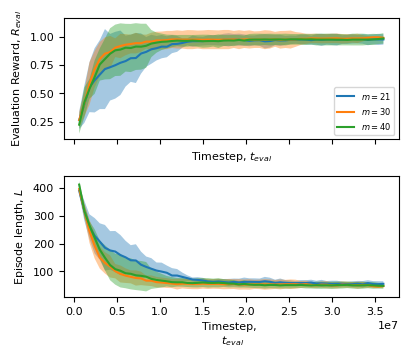

In [104]:
# produce figures for appendix (message size for 6 landmarks and beta=2)
all_experiments = ["/media/XXX/LaCie/aamas_2023/paper/message_size"]
labels_to_print = {"naming_game_21msg_alpha10_temp30": "$m=21$",
                  "naming_game_30msg_alpha10_temp30": "$m=30$",
                  "naming_game_40msg_alpha10_temp30": "$m=40$"}
correct_order = ["$m=21$", "$m=30$", "$m=40$"]
ncols = 1
beta = 2
best_reward = (6/21*1/beta + 15/21)*2
produce_plots(all_experiments, labels_to_print, correct_order, best_reward)

2022-10-26_10-47-46mqinyg2q
2022-10-26_10-47-46dpqioiym
2022-10-26_10-47-465x9bllxc
2022-10-26_10-47-46dd50e48j
2022-10-26_10-47-469_vrnfa0
2022-10-27_19-19-56_8ve71_y
2022-10-27_19-21-22pozgzx7i
2022-10-27_19-24-53qlfxv7fz
2022-10-27_19-24-53kh4dr43g
2022-10-27_19-14-40v1v3_6dl
2022-10-25_22-08-58xaiqoof4
2022-10-25_22-09-51syxc5pzg
2022-10-25_22-09-51k8geuafu
2022-10-25_22-08-56l41yglp8
2022-10-25_22-08-57ly83qsjy
2022-10-26_12-15-23y4jdt2r3
2022-10-26_12-15-23jslpcvln
2022-10-26_12-15-23rycgr57t
2022-10-26_12-15-2340ge5d8u
2022-10-26_12-15-23qld7kd3q
actual label $\beta=1$
actual label $\beta=2$
actual label $\beta=4$
actual label $\beta=8$
here 2 $\beta=2$
here 1 $\beta=1$
here 4 $\beta=4$
here 8 $\beta=8$


<Figure size 412.598x354.331 with 0 Axes>

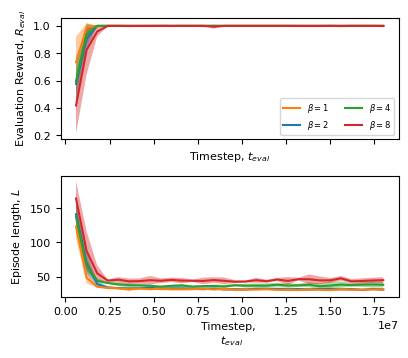

In [85]:

all_experiments = ["/media/XXX/LaCie/aamas_2023/paper/multiplier/3_landmarks"]
labels_to_print = {"naming_game_reward1": "$\\beta=1$",
                   "naming_game_reward2": "$\\beta=2$",
                  "naming_game_reward4": "$\\beta=4$",
                  "naming_game_reward8": "$\\beta=8$"}
correct_order = ["$\\beta=1$", "$\\beta=2$", "$\\beta=4$", "$\\beta=8$"]
ncols = 2
beta_values = {"$\\beta=1$": 1, "$\\beta=2$": 2, "$\\beta=4$":4, "$\\beta=8$":8 }
produce_plots(all_experiments, labels_to_print, correct_order, best_reward=0, beta_values=beta_values)

2022-10-24_12-32-23w38n9k1v
2022-10-24_12-32-23k9gh_tpn
2022-10-24_12-32-23051i1mz4
2022-10-24_12-32-236gdeixcf
2022-10-24_12-32-23y3j1bw5n
centralized
2022-10-24_12-34-041rxhavoe
2022-10-24_12-34-04krirauq2
2022-10-24_12-34-04vo1pq07v
2022-10-24_12-34-043mxryns0
2022-10-24_12-34-04iqbfys2o
independent
2022-10-25_22-08-58xaiqoof4
2022-10-25_22-09-51syxc5pzg
2022-10-25_22-09-51k8geuafu
2022-10-25_22-08-56l41yglp8
2022-10-25_22-08-57ly83qsjy
naming_game_30msg_alpha10_temp30
2022-10-24_14-43-07hp2pnmci
2022-10-24_14-43-06_ddrqmpl
2022-10-24_14-43-07fgw6a6f7
2022-10-24_14-43-06vyf4_pam
2022-10-24_14-43-07c4e0t6cl
50align
$100%$-align
0      0.030734
1      0.048438
2      0.072933
3      0.130717
4      0.177518
         ...   
295    1.247228
296    1.251073
297    1.252955
298    1.244115
299    1.245719
Length: 300, dtype: float64
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,

<Figure size 412.598x354.331 with 0 Axes>

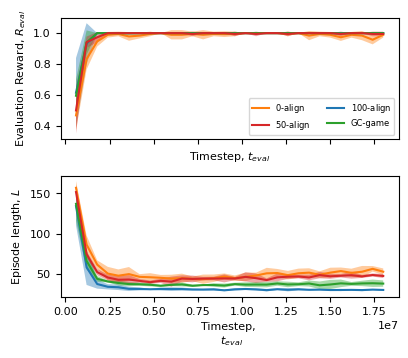

In [64]:
all_experiments = ["/media/XXX/LaCie/aamas_2023/all/3_landmarks//3_landmarks_reward4"]
labels_to_print = {"0align": "$0%$-align",
                   "independent": "$0%$-align",
                   "centralized": "$100%$-align",
                   "75align": "$75%$-align",
                     "25align": "$25%$-align",

                  "50align": "$50%$-align",
                  "100align": "$100%$-align",
                  "naming_game_30msg_alpha10_temp30": "GC-game"}
beta=4
best_reward = (1/2*1/beta + 1/2)*2

correct_order = ["$0%$-align", "$50%$-align", "$100%$-align","GC-game" ]
produce_plots(all_experiments, labels_to_print, correct_order, best_reward)